In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing import image
base_model = ResNet50(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
prediction=Dense(3,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=prediction)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
for layer in model.layers[:40]:
    layer.trainable=False
for layer in model.layers[40:]:
    layer.trainable=True

In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [6]:
#Used to setup Google drive
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
def resized(img_path):
  img = cv.imread(img_path)
  img = cv.resize(img,(128,128))
  img = img/255.0
  return img

def image_generator(X,y, batch_size):
  while True:
    batch  = np.random.choice(len(X),size = batch_size)
    batch_input  = []
    batch_output = []
    
    for i in batch:
      try:
        output = y[i]
        input = resized(X[i][0])
        batch_input += [input]
        batch_output += [output]

      except:
        pass

    batch_x = np.array(batch_input)
    batch_y = np.array(batch_output)
    
    yield (batch_x, batch_y)

In [0]:
path = "/content/drive/My Drive/Kaggle/chest_xray/"

normal = open(path + "normal.txt").read()
normal = normal.split("\n")

covid = open(path + "covid.txt").read()
covid = covid.split("\n")

pneumonia = open(path+"pneumonia.txt").read()
pneumonia = pneumonia.split("\n")

normal = [[i,0] for i in normal]
covid  = [[j,1] for j in covid]
pneumonia = [[k,2] for k in pneumonia]

cases = np.array(normal + covid + pneumonia)

In [0]:
X = cases[:,0].reshape(-1,1)
y = cases[:,1]

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
y = np_utils.to_categorical(encoded_Y)


X_train, X_valid, y_train, y_valid = train_test_split(X,y, stratify = y, test_size = 0.2, random_state=111)

In [9]:
X_train[:10]

array([['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/NORMAL2-IM-0965-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/covid-chestxray-dataset/images/covid-19-pneumonia-35-2.jpg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/NORMAL2-IM-1120-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/IM-0545-0001-0002.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/NORMAL2-IM-0896-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/NORMAL2-IM-0413-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/NORMAL2-IM-1049-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/IM-0733-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/NORMAL2-IM-0599-0001.jpeg'],
       ['/content/drive/My Drive/Kaggle/chest_xray/train/NORMAL/IM-0234-0001.jpeg']],
      dtype='<U156')

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
checkpoint1 = ModelCheckpoint(filepath="weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
results = model.fit_generator(image_generator(X_train,y_train,12),steps_per_epoch=100, epochs=10,validation_data=image_generator(X_valid,y_valid,10),validation_steps=31,callbacks = [checkpoint1])

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


 42/100 [===========>..................] - ETA: 10:53 - loss: 0.2770 - accuracy: 0.9124

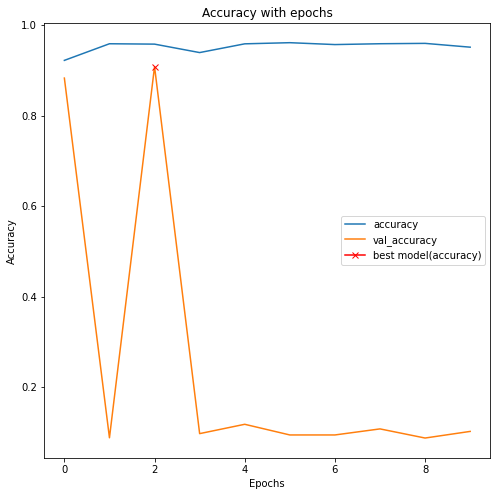

In [73]:
 plt.figure(figsize=(8, 8))
plt.title("Accuracy with epochs")
plt.plot(results.history['accuracy'], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model(accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()